In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost
import lightgbm

In [2]:
import artemis

In [3]:
from artemis.interactions_methods.model_specific import SplitScoreMethod

In [14]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target
model = xgboost.XGBRegressor(max_depth=8, n_estimators=40).fit(X, y)
model_lgbm = lightgbm.LGBMRegressor(max_depth=3).fit(X, y)

In [15]:
split_score = SplitScoreMethod()

In [16]:
split_score.fit(model, )

In [17]:
split_score.variable_importance

,Feature,Value
0,MedInc,21.981173
1,AveOccup,7.762682
2,Latitude,5.041224
3,Longitude,5.033153
4,HouseAge,3.202411
5,AveRooms,2.330842
6,Population,1.341333
7,AveBedrms,1.161633


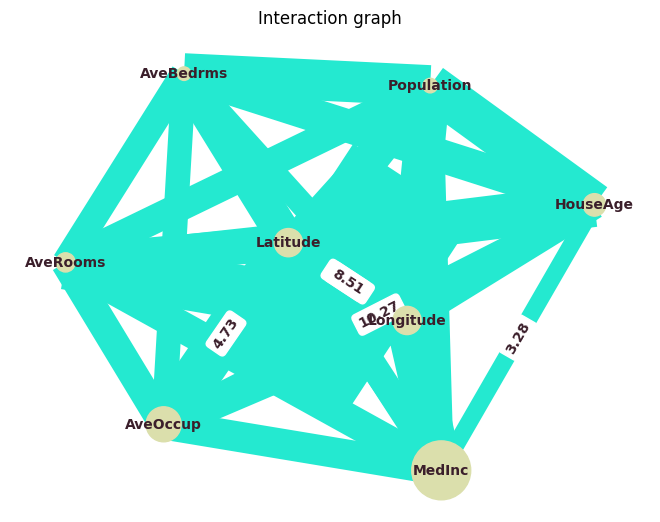

In [18]:
split_score.plot(vis_type="interaction graph")

In [20]:
import matplotlib.pyplot as plt

In [29]:
fig = plt.figure()
plt.title("OK")
plt.close()
2 + 2

4

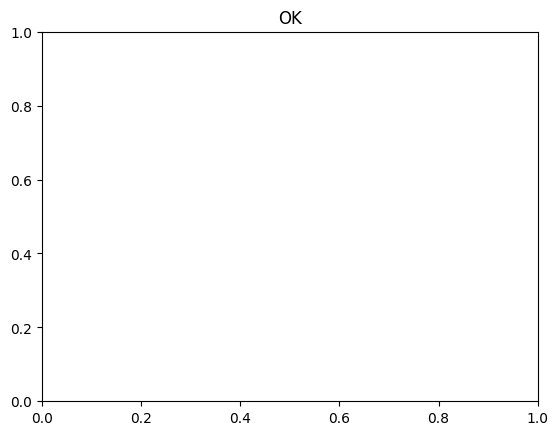

In [30]:
fig

In [19]:
trees_df = split_score.full_result
trees_df

,tree,ID,depth,split_feature,parent_name,gain,cover,parent_gain,parent_cover,leaf,interaction
0,0,0-0,0,MedInc,NaN,8512.257810,20640.0,NaN,NaN,False,NaN
1,0,0-1,1,MedInc,MedInc,2172.193360,16255.0,8512.25781,20640.0,False,False
2,0,0-2,1,MedInc,MedInc,1586.050780,4385.0,8512.25781,20640.0,False,False
3,0,0-3,2,AveRooms,MedInc,397.370117,7860.0,2172.19336,16255.0,False,False
4,0,0-4,2,AveOccup,MedInc,1249.347660,8395.0,2172.19336,16255.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...
13947,39,39-272,None,Leaf,NaN,0.001573,1201.0,NaN,NaN,True,NaN
13948,39,39-273,None,Leaf,NaN,0.149564,2.0,NaN,NaN,True,NaN
13949,39,39-274,None,Leaf,NaN,0.000304,4.0,NaN,NaN,True,NaN
13950,39,39-275,None,Leaf,NaN,-0.025026,148.0,NaN,NaN,True,NaN


In [57]:
def _calculate_all_variable_importance(trees_df, features = None): 
    if features is not None:
        trees_df = trees_df.loc[trees_df["split_feature"].isin(features)]
    else: 
        trees_df = trees_df.loc[trees_df["split_feature"] != "Leaf"]
    importance_full_result = trees_df.groupby("split_feature").agg(
        mean_gain = ('gain', 'mean'), 
        sum_gain = ('gain', 'sum'),
        mean_cover = ('cover', 'mean'),
        sum_cover = ('cover', 'sum'),
        mean_depth = ('depth', 'mean'))
    root_freq_df = trees_df.loc[trees_df["depth"] == 0].groupby("split_feature").agg(
        root_frequency = ('tree', 'count'),
        sum_gain_root = ('gain', 'sum'))
    sum_gain = np.sum(root_freq_df.sum_gain_root)
    root_freq_df["weighted_root_frequency"] = root_freq_df["root_frequency"] * root_freq_df["sum_gain_root"] / sum_gain
    importance_full_result = importance_full_result.join(root_freq_df[["root_frequency", "weighted_root_frequency"]])
    importance_full_result = pd.concat([importance_full_result, 
    pd.Series(trees_df.groupby("split_feature").apply(lambda x: np.average(x.depth, weights=x.gain)), name = "mean_weighted_depth")], axis=1)
    # importance_full_result["root_frequency"] = 
    

        # mean_weighted_depth = ('tree', 'count'),
        # root_frequency = ,
        # weighted_root_frequency = )
        
        
    # sort_values("sum_gain", ascending=False) pd.concat
    return importance_full_result


In [58]:
_calculate_all_variable_importance(trees_df)

,mean_gain,sum_gain,mean_cover,sum_cover,mean_depth,root_frequency,weighted_root_frequency,mean_weighted_depth
split_feature,,,,,,,,
AveBedrms,7.992189,319.687578,9918.575000,396743.0,1.375000,7.0,0.047550,0.906596
AveOccup,68.374280,5743.439490,8060.047619,677044.0,1.500000,9.0,0.100691,1.748194
AveRooms,12.122901,1006.200770,9978.879518,828247.0,1.289157,19.0,0.112427,1.644084
HouseAge,25.180783,1536.027765,4165.557377,254099.0,1.721311,NaN,NaN,1.672879
Latitude,28.657945,4212.717880,10028.863946,1474243.0,1.435374,20.0,0.089255,1.340102
Longitude,44.257340,6196.027646,9366.400000,1311296.0,1.407143,18.0,0.672747,1.672299
MedInc,259.336583,26192.994835,9597.049505,969302.0,1.287129,21.0,19.597381,0.359270
Population,6.708253,214.664101,8781.500000,281008.0,1.468750,6.0,0.006334,1.673855


,root_frequency,sum_gain_root,weighted_root_frequency
split_feature,,,
AveBedrms,7,130.427507,0.047550
AveOccup,9,214.814764,0.100691
AveRooms,19,113.613984,0.112427
Latitude,20,85.687813,0.089255
Longitude,18,717.618386,0.672747
MedInc,21,17918.137683,19.597381
Population,6,20.270193,0.006334


In [42]:
root_frequency

MedInc        21
Latitude      20
AveRooms      19
Longitude     18
AveOccup       9
AveBedrms      7
Population     6
Name: root_frequency, dtype: int64

In [22]:
mean_weighted_depth

MedInc        21
Latitude      20
AveRooms      19
Longitude     18
AveOccup       9
AveBedrms      7
Population     6
Name: x, dtype: int64

In [10]:
trees_df.loc[trees_df["depth"] == 0, "split_feature"].value_counts()

MedInc        21
Latitude      20
AveRooms      19
Longitude     18
AveOccup       9
AveBedrms      7
Population     6
Name: split_feature, dtype: int64

In [7]:
split_score.ovo

,parent_variable,child_variable,mean_gain,sum_gain,mean_cover,sum_cover,mean_depth,frequency
31,Latitude,Longitude,89.474138,4473.706877,9057.580000,452879.0,1.520000,50
37,Longitude,Latitude,37.344053,1829.858574,9390.551020,460137.0,1.551020,49
40,MedInc,AveOccup,66.438751,465.071258,9520.571429,66644.0,1.571429,7
21,HouseAge,AveOccup,112.873414,338.620241,6755.333333,20266.0,2.000000,3
8,AveOccup,HouseAge,16.374661,278.369232,6240.117647,106082.0,1.647059,17
23,HouseAge,Latitude,61.148049,183.444148,7623.000000,22869.0,2.000000,3
9,AveOccup,Latitude,56.994576,170.983727,10588.333333,31765.0,1.333333,3
38,Longitude,MedInc,21.453870,107.269350,1730.400000,8652.0,2.000000,5
14,AveRooms,AveOccup,8.753862,105.046345,8076.250000,96915.0,1.166667,12
41,MedInc,AveRooms,5.713569,102.844240,10673.333333,192120.0,1.333333,18
